In [154]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
BASE_DIR="/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/"

RES_DIR1 = BASE_DIR + "final_results4"
#RES_DIR2 = BASE_DIR + "sample_bitmaps_load"
#RES_DIR3 = BASE_DIR + "sample_bitmaps/"

assert os.path.exists(RES_DIR1)
assert os.path.exists(RES_DIR2)

SAVE_DIR ="./figures/results1/"
make_dir(SAVE_DIR)
FN_TMP = "{ERROR_TYPE}-{SAMPLES_TYPE}-{PART}.png"

COLORS = {}
COLORS["Flow Loss"] = "blue"
COLORS["Flow Loss Bitmap"] = "lightblue"

COLORS["Q-Error"] = "green"
COLORS["Q-Error Bitmap"] = "lightgreen"

LINESTYLES = {}
LINESTYLES["Flow Loss"] = ":"
LINESTYLES["Q-Error"] = "--"
LINESTYLES["Flow Loss Bitmap"] =  ":"
LINESTYLES["Q-Error Bitmap"] = "--"

# LINESTYLES["Flow Loss Bitmap"] =  (0, (3, 10, 1, 10))
# LINESTYLES["Q-Error Bitmap"] = (0, (3, 10, 1, 10))

ALG_KEY = {}
ALG_KEY["flow_loss2"] = "Flow Loss"
ALG_KEY["flow_loss2_bitmap"] = "Flow Loss Bitmap"

ALG_KEY["mse"] = "Q-Error"
ALG_KEY["mse_bitmap"] = "Q-Error Bitmap"

In [156]:
def arg_filters(df):
    #tmp = df2[df2["template"] == "all_job"]
    #tmp = tmp[tmp["partition"] == 2]
    #tmp = tmp[tmp["alg"] == "flow_loss2"]
    tmp = df[df["flow_features"] == 1]
    tmp = tmp[tmp["hidden_layer_size"] == 512]
    tmp = tmp[tmp["feat_rel_pg_ests_onehot"] == 1]
    return tmp

def get_alg_name(cols, x):
    name = ""
    for col in cols:
        if col == "sample_bitmap":
            if x["sample_bitmap"]:   
                name += "_bitmap"
        else:
            name += x[col]
    return name

In [157]:
#df1 = get_all_objects(RES_DIR, "query_qerr.pkl")
#df1 = get_all_objects(RES_DIR, "all_qerr.pkl")
#df2 = get_all_objects(RES_DIR, "cm1_jerr.pkl")
#df3 = get_all_objects(RES_DIR, "flow_err.pkl")
#plan_err = get_all_objects(RES_DIR, "plan_err.pkl")

RES_DIRS = []
RES_DIRS.append(RES_DIR1)
#RES_DIRS.append(RES_DIR2)
#RES_DIRS.append(RES_DIR3)

df1s = []
df2s = []
for res_dir in RES_DIRS:
    qerr = get_all_objects(res_dir, "all_qerr.pkl")
    jerr = get_all_objects(res_dir, "cm1_jerr.pkl")
    if "bitmap" in res_dir:
        qerr["sample_bitmap"] = 1
        jerr["sample_bitmap"] = 1
 
    df1s.append(qerr)
    df2s.append(jerr)
    
df1 = pd.concat(df1s, ignore_index=True)
df2 = pd.concat(df2s, ignore_index=True)

skipping obj:  all_qerr.pkl
skipping obj:  cm1_jerr.pkl


In [158]:
cols = ["alg", "sample_bitmap"]
set(df2["samples_type"])
print(set(df2["alg"]))
#df2["alg_name"] = df2.apply(lambda x: x["alg"]+ str(x["sample_bitmap"]), axis=1)
#print(len(df2))

#df1['alg'] = df1[cols].apply(lambda row: get_alg_name(cols, row), axis=1)
#df2['alg'] = df2[cols].apply(lambda row: get_alg_name(cols, row), axis=1)
print(set(df2["alg"]))

{'flow_loss2', 'mse'}
{'flow_loss2', 'mse'}


In [159]:
def compute_PDF(arr, num_bins=600):
    """
    usage: x, y = compute_PDF(arr):
           plt.plot(x, y)
    """
    values, base = np.histogram(arr, bins=num_bins)
    cumulative = np.cumsum(values)
    return base[:-1], cumulative / float(cumulative[-1])  # this is for CDF

In [1]:
#TITLE_FMT = "{SAMPLES}-{PARTITION}"
TITLE_KEYS = {}
TITLE_KEYS["job"] = "Join Order Benchmark"
TITLE_KEYS["test"] = "Test Set"
TITLE_KEYS["train"] = "Train Set"

def plot_cdf_jerr(samples_type, df, part):
    #plt.gcf()
    fn = FN_TMP.format(ERROR_TYPE = "postgres",
                       SAMPLES_TYPE = st,
                       PART = part)
    fn = SAVE_DIR + fn
    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')   

    df = df[df.samples_type == samples_type]
    algs = set(df["alg"])
    
    plt.title(TITLE_KEYS[samples_type] + "-" + str(part))

    for alg in algs:
        if alg == "true" or alg == "postgres":
            continue
        tmp_df = df[df.alg == alg]
        
        alg_label = ALG_KEY[alg]

        losses = tmp_df["loss"].values
        x, y = compute_PDF(losses, num_bins=len(losses))
        #x, y = compute_PDF(losses, num_bins=600)
        plt.plot(x, y, label = alg_label, linestyle=LINESTYLES[alg_label], linewidth=3, color = COLORS[alg_label])
        #plt.plot(x, y, label = alg_label, linestyle="--", linewidth=3, color = COLORS[alg_label])

        plt.xscale("log")
        plt.legend(frameon=False)
    plt.savefig(fn)
    plt.show()

def plot_cdf_qerr(samples_type, df,part):
    fn = FN_TMP.format(ERROR_TYPE = "qerror",
                       SAMPLES_TYPE = st,
                       PART = part)
    fn = SAVE_DIR + fn

    plt.figure(figsize=(5,4))
    plt.style.use('ggplot')   

    plt.title(TITLE_KEYS[samples_type] + "-" + str(part))
    
    algs = set(df["alg"])
    for alg in algs:
        if alg == "true" or alg == "postgres":
            continue
        #alg = ALG_KEYS[alg]
        tmp_df = df[df.alg == alg]
        
        alg_label = ALG_KEY[alg]

        #losses = tmp_df["qerr"].values
        losses = tmp_df["loss"].values
        x, y = compute_PDF(losses, num_bins=600)
        plt.plot(x, y, label = alg_label, linestyle="--", linewidth=3, color = COLORS[alg_label])
        plt.xscale("symlog")
        #plt.yscale("log")
        plt.legend(frameon=False)
    plt.savefig(fn)
    plt.show()


In [2]:
SAMPLES_TYPES = ["test", "job"]
#SAMPLES_TYPES = ["test", "job"]

for st in SAMPLES_TYPES:
    for part in set(df2["partition"]):
        tmp_df = df2[df2.partition == part]
        plot_cdf_jerr(st, tmp_df, part)

NameError: name 'df2' is not defined

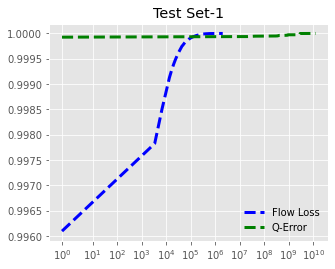

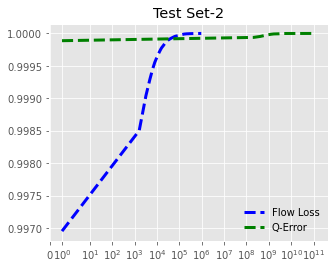

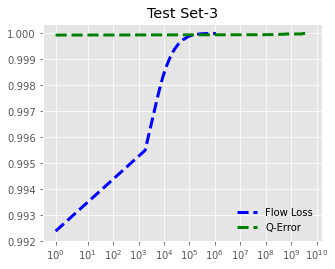

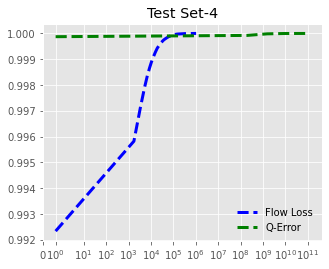

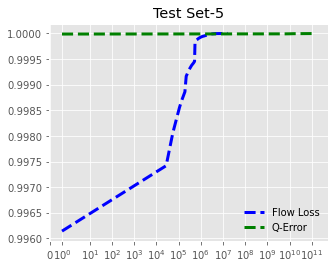

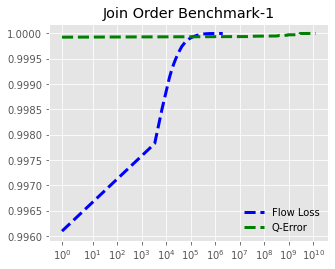

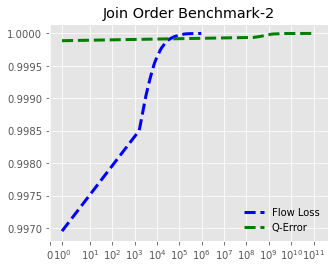

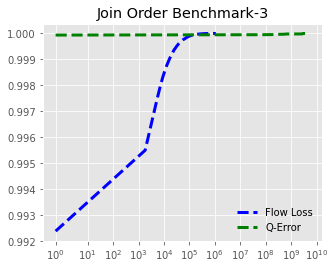

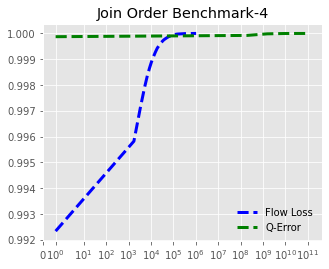

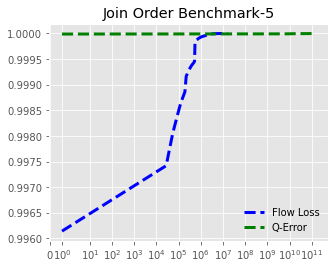

In [162]:
SAMPLES_TYPES = ["test", "job"]
#SAMPLES_TYPES = ["test", "job"]

for st in SAMPLES_TYPES:
    for part in set(df1["partition"]):
        tmp_df = df1[df1.partition == part]
        plot_cdf_qerr(st, tmp_df, part)

In [114]:
# for part in set(df1["partition"]):
#     tmp_df = df1[df1.partition == part]
#     plot_cdf_qerr("test", tmp_df)

for st in SAMPLES_TYPES:
    cur_df = plan_err[plan_err.samples_type == st]
    for part in set(plan_err["partition"]):
        tmp_df = cur_df[cur_df.partition == part]
        plot_cdf_jerr(st, tmp_df, part)

NameError: name 'plan_err' is not defined

In [115]:
df1["qerr"].notnull()

KeyError: 'qerr'

In [116]:
tmp = df2[df2["template"] == "all_job"]
tmp = tmp[tmp["partition"] == 2]
tmp = tmp[tmp["alg"] == "flow_loss2"]
tmp = tmp[tmp["flow_features"] == 1]
tmp = tmp[tmp["feat_rel_pg_ests_onehot"] == 1]

KeyError: 'feat_rel_pg_ests_onehot'

In [117]:
print(len(tmp))
print(set(tmp["num_hidden_layers"]))
print(set(tmp["hidden_layer_size"]))
print(set(tmp["flow_features"]))
print(set(tmp["feat_rel_pg_ests_onehot"]))

108


KeyError: 'num_hidden_layers'

In [163]:
def shaded_plot_cdf(samples_type, df, error_type, err_bar):
    plt.style.use('ggplot')   
    fig  = plt.figure(figsize=(5,4))
    ax = plt.gca()
    df = df[df.samples_type == samples_type]
    algs = list(set(df["alg"]))
    print(algs)
    #clrs = sns.color_palette("husl", 5)
    
    fn = FN_TMP.format(ERROR_TYPE = error_type,
                       SAMPLES_TYPE = samples_type,
                       PART = err_bar)
    fn = SAVE_DIR + fn

    plt.title(TITLE_KEYS[samples_type] + "-" + error_type)
    print(fn)

    for i, alg in enumerate(algs):
        if alg == "true" or alg == "postgres":
            continue
            
        alg_label = ALG_KEY[alg]
        tmp_df = df[df.alg == alg]  
        Y = []
        X = []
        
        for part in set(tmp_df.partition):
            tmp = tmp_df[tmp_df.partition == part]
            #tmp = tmp[tmp.loss >= 5e6]
            x, y = compute_PDF(tmp.loss.values, num_bins=20000)
            Y.append(y)
            X.append(x)
    
        X = np.array(X)
        X = np.mean(X, axis=0)
        Y = np.array(Y)
        print(Y.shape)
        maxs = np.max(Y, axis=0)
        mins = np.min(Y, axis=0)
        stds = np.std(Y, axis=0)
        means = np.mean(Y, axis=0)
        
        ax.plot(X, means, label=alg_label, color=COLORS[alg_label], linestyle="--")

        if err_bar == "minmax":
            ax.fill_between(X, mins, maxs ,alpha=0.3, facecolor=COLORS[alg_label])
        else:
            ax.fill_between(X, means-stds, means+stds ,alpha=0.2, facecolor=COLORS[alg_label])

        plt.xscale("log")
        plt.legend()
        
    plt.savefig(fn)

In [164]:
Y = []
test_df = df2[df2.samples_type == "test"]
for part in set(test_df.partition):
    tmp = test_df[test_df.partition == part]
    x, y = compute_PDF(tmp.loss.values, num_bins=600)
    Y.append(y)
Y = np.array(Y)
print(Y.shape)

(5, 600)


['flow_loss2', 'mse']
./figures/results1/Postgres Plan Error-test-minmax.png
(5, 20000)
(5, 20000)
['flow_loss2', 'mse']
./figures/results1/Postgres Plan Error-test-std.png
(5, 20000)
(5, 20000)


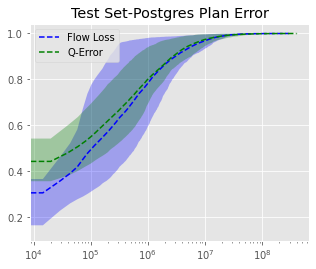

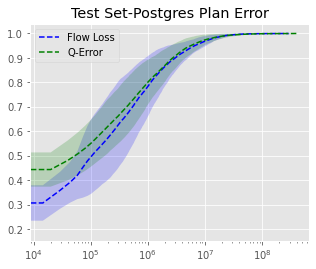

In [165]:
shaded_plot_cdf("test", df2, "Postgres Plan Error", "minmax")
shaded_plot_cdf("test", df2, "Postgres Plan Error", "std")

['flow_loss2', 'mse']
./figures/results1/Postgres Plan Error-job-minmax.png
(5, 20000)
(5, 20000)
['flow_loss2', 'mse']
./figures/results1/Postgres Plan Error-job-std.png
(5, 20000)
(5, 20000)


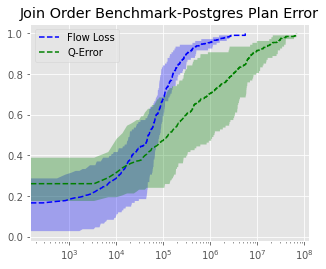

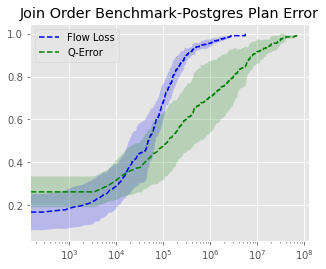

In [166]:
shaded_plot_cdf("job", df2, "Postgres Plan Error", "minmax")
shaded_plot_cdf("job", df2, "Postgres Plan Error", "std")

['flow_loss2', 'mse']
./figures/results1/Q-Error-test-minmax.png
(5, 20000)
(5, 20000)
['flow_loss2', 'mse']
./figures/results1/Q-Error-test-std.png
(5, 20000)
(5, 20000)


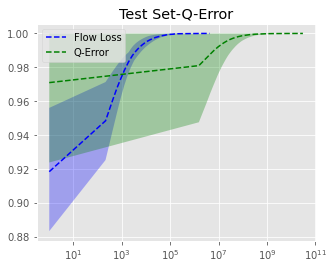

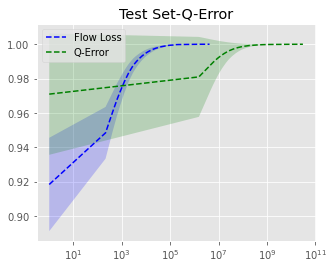

In [167]:
shaded_plot_cdf("test", df1, "Q-Error", "minmax")
shaded_plot_cdf("test", df1, "Q-Error", "std")

['flow_loss2', 'mse']
./figures/results1/Q-Error-job-minmax.png
(5, 20000)
(5, 20000)
['flow_loss2', 'mse']
./figures/results1/Q-Error-job-std.png
(5, 20000)
(5, 20000)


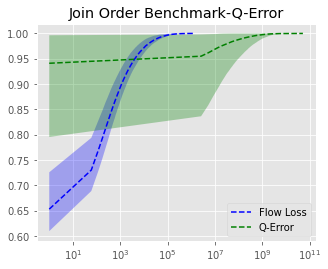

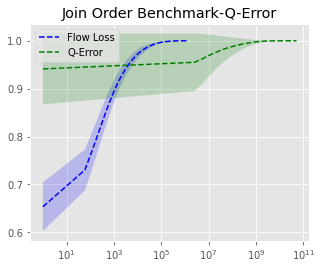

In [168]:
shaded_plot_cdf("job", df1, "Q-Error", "minmax")
shaded_plot_cdf("job", df1, "Q-Error", "std")